In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import pytorch_lightning
from pytorch_lightning.callbacks import EarlyStopping
# from torch.optim

In [6]:
data = cifar100.load_data(label_mode='fine')
(x_train, y_train), (x_test, y_test) = data
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)


class AutoEncoder(nn.Module):
    def __init__(self, latent_dim): # input_dim is not used for this Conv architecture
        super(AutoEncoder, self).__init__()
        self.encoder_feature_dim = 64 * 4 * 4 # Calculate this based on conv output

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Output: (256, 4, 4)
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # Output: (512, 2, 2)
            nn.Flatten(),  # Flatten to (batch_size, 128 * 8 * 8)
            nn.Linear(512 * 2 * 2, latent_dim),  # Linear layer to latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 2 * 2),  # Linear layer to reshape to (128, 8, 8)
            nn.Unflatten(dim=1, unflattened_size=(512 ,2 ,2)),  # Unflatten to (batch_size, 128, 8, 8)
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (256, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (3, 32, 32)
            nn.Sigmoid()  # Sigmoid to normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


autoencoder = AutoEncoder(latent_dim=64)
autoencoder = autoencoder.cuda()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# loss = nn.MSELoss()
loss = nn.BCELoss()


def train_autoencoder(model, data, epochs=100, batch_size=64):
    model.train()
    num_samples = data.shape[0]
    num_batches = num_samples // batch_size
    for epoch in tqdm(range(epochs)):
        loss_value = 0
        for i in range(num_batches):
            batch_data = data[i * batch_size:(i + 1) * batch_size]
            batch_data = torch.tensor(batch_data).permute(0, 3, 1, 2).cuda()  # Convert to tensor and permute to (N, C, H, W)
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss_value = loss(reconstructed, batch_data)
            loss_value.backward()
            optimizer.step()
            # scheduler.step()

        if (epoch) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss_value.item():.4f}')
            

def predict(model, data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).permute(0, 3, 1, 2).cuda()  # Convert to tensor and permute to (N, C, H, W)
        reconstructed = model(data_tensor)
        return reconstructed.cpu().numpy().transpose(0, 2, 3, 1)  # Convert back to (N, H, W, C)

x_test = x_test.astype(np.float32) / 255.0  # Normalize the data
np.random.shuffle(x_test)  # Shuffle the test data
train_autoencoder(autoencoder, x_test)


x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000, 1)


  1%|          | 1/100 [00:14<24:07, 14.62s/it]

Epoch [1/100], Loss: 0.6929


 11%|█         | 11/100 [01:11<05:38,  3.80s/it]

Epoch [11/100], Loss: 0.6948


 21%|██        | 21/100 [01:50<06:06,  4.64s/it]

Epoch [21/100], Loss: 0.6948


 31%|███       | 31/100 [03:11<09:14,  8.04s/it]

Epoch [31/100], Loss: 0.6949


 41%|████      | 41/100 [12:20<1:21:03, 82.43s/it]

Epoch [41/100], Loss: 0.6949


 51%|█████     | 51/100 [27:41<57:38, 70.58s/it]   

Epoch [51/100], Loss: 0.6949


 61%|██████    | 61/100 [28:15<03:31,  5.41s/it]

Epoch [61/100], Loss: 0.6949


 71%|███████   | 71/100 [29:19<04:11,  8.68s/it]

Epoch [71/100], Loss: 0.6949


 81%|████████  | 81/100 [31:12<03:35, 11.36s/it]

Epoch [81/100], Loss: 0.6949


 91%|█████████ | 91/100 [33:38<02:51, 19.04s/it]

Epoch [91/100], Loss: 0.6949


100%|██████████| 100/100 [36:41<00:00, 22.01s/it]


In [3]:
print(x_test.min(), x_test.max(), x_test.mean())


0.0 1.0 0.47937745


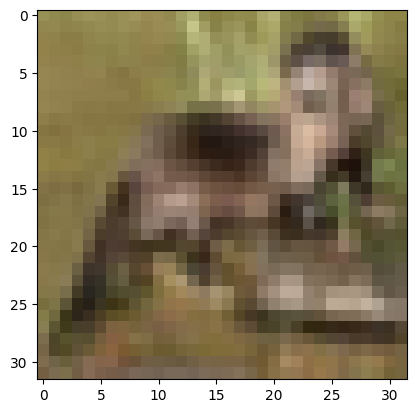

In [4]:
plt.imshow(x_train[100])

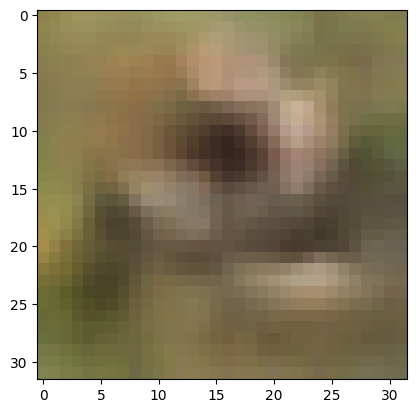

In [5]:
x_100 = x_train[100].astype(np.float32) / 255.0  # Normalize the single image
x_100 = x_100.reshape(1, 32, 32, 3)  # Reshape to (1, H, W, C)
reconstructed_image = predict(autoencoder, x_100)
plt.imshow(reconstructed_image[0])